# Analyzing SQL Workloads

This Jupyter Notebook contains examples of how to use the open APIs of the Db2 Data Management Console to run SQL scripts and use Visual Explain in to analyze SQL. You will start with single SQL statements and work up to running multiple statements against multiple databases to simulate a production workload. By measuring performance over several runs you can identify the slowest statement and the slowest database. Finally you can experiment with different indexes to see if you can improve the performance of the workload. 

The Db2 Data Management Console is more than a graphical user interface. It is a set of microservices that you can use to build custom applications to automate your use of Db2.

This Jupyter Notebook contains examples of how to use the Open APIs and the composable interface that are available in the Db2 Data Management Console. Everything in the User Interface is also available through an open and fully documented RESTful Services API. The full set of APIs are documented as part of the Db2 Data Management Console user interface. In this hands on lab you can connect to the documentation directly through this link: [Db2 Data Management Console RESTful APIs](http://localhost:11080/dbapi/api/index_enterprise.html). 

You can also embed elements of the full user interface into an IFrame by constructing the appropriate URL.

This hands on lab will be calling the Db2 Data Management Console as a service. However you can explore it through the user interface as well. Just click on the following link to try out the console that is already and setup in this lab: http://localhost:11080/console. If you have not already logged in you can use the following:
* Userid: db2inst1
* Password: db2inst1

### Where to find this sample online
You can find a copy of this notebook at https://github.com/Db2-DTE-POC/db2dmc.

### Import Helper Classes
For more information on these classes, see the lab: [Automate Db2 with Open Console Services](http://localhost:8888/notebooks/Db2_Data_Management_Console_Overview.ipynb)

In [1]:
%run ./dmc_setup.ipynb

### Db2 Data Management Console Connection
To connect to the Db2 Data Management Console service you need to provide the URL, the service name (v4) and profile the console user name and password as well as the name of the connection profile used in the console to connect to the database you want to work with. For this lab we are assuming that the following values are used for the connection:
* Userid: db2inst1
* Password: db2inst1
* Connection: sample

**Note:** If the Db2 Data Management Console has not completed initialization, the connection below will fail. Wait for a few moments and then try it again.

In [2]:
# Connect to the Db2 Data Management Console service
Console  = 'http://localhost:11080'
profile  = 'SAMPLE'
user     = 'DB2INST1'
password = 'db2inst1'

# Set up the required connection
profileURL = "?profile="+profile
databaseAPI = Db2(Console+'/dbapi/v4')

if databaseAPI.authenticate(user, password, profile) :
    print("Token Created")
else : 
    print("Token Creation Failed")
database = Console

Token Created


### Confirm the connection
To confirm that your connection is working you can check the status of the moitoring service. You can also check your console connection to get the details of the specific database connection you are working with. Since your console user id and password may be limited as to which databases they can access you need to provide the connection profile name to drill down on any detailed information for the database.

In [3]:
# List Monitoring Profile
r = databaseAPI.getProfile(profile)
json = databaseAPI.getJSON(r)
print(json)

{'name': 'SAMPLE', 'disableDataCollection': 'false', 'databaseVersion': '11.5.0', 'databaseName': 'SAMPLE', 'timeZone': '-50000', 'DB2Instance': 'db2inst1', 'db2license': 'AESE,DEC', 'isInstPureScale': 'false', 'databaseVersion_VRMF': '11.5.0.0', 'sslConnection': 'false', 'userProfileRole': 'OWNER', 'timeZoneDiff': '0', 'host': 'localhost', '_PROFILE_INIT_': 'true', 'dataServerType': 'DB2LUW', 'port': '50000', 'URL': 'jdbc:db2://localhost:50000/SAMPLE', 'edition': 'AESE,DEC', 'isInstPartitionable': 'false', 'dataServerExternalType': 'DB2LUW', 'capabilities': '["DSM_ENTERPRISE_LUW"]', 'OSType': 'Linux', 'location': ''}


### Using the Db2 class to run SQL
You can use the console API to run single SQL statement or sets of statements in a single call. A step by step explanation of running SQL through the Db2 Data Management Console SQL service is available in the [Db2 SQL with RESTful Services](http://localhost:8888/notebooks/Db2_RESTful_APIS.ipynb) Jupyter notebook. These examples use the Db2 class defined in [dmc_setup.ipynb](http://localhost:8888/notebooks/dmc_setup.ipynb). The Db2 class takes care of creating a reusable authentication key from your login information. It includes two routines **runSQL** and **getSQLJobResult** that make submitting SQL scripts easy. **runSQL** uses the console service to run one or more statements in the background, saving the result. **getSQLJobResult** lets you access the results of each statement.  

In this first example we will run a single statement. The first step defines a single statement, runs the SQL and retrieves a unique id to identify the SQL running in the background. Using that id you can check the job results to see if it is still running or complete. 

In [4]:
#Run SQL Statement and Retrieve the identifier used to track the run

# Define the SQL to Run
sqlText = 'select TABSCHEMA, TABNAME from syscat.tables'

# Run SQL throught the Console SQL Editor REST Service
r = databaseAPI.runSQL(sqlText)

# Retrieve the run identifier from the SQL Editor Service
runID = databaseAPI.getJSON(r)['id'] 

# Using the saved runID retrieve a JSON description of the run
json = databaseAPI.getJSON(databaseAPI.getSQLJobResult(runID)) 

# Extract the status of the run from the JSON return and print the runID as well as its status
if json['results'] == [] :
    print(runID+" "+json['status']) 
else :
    print('JSON Results')
    print(json['results']) 

1580838630993_893901443 running


In the next step we check that the statement has finished running. Then we check for three possible conditions. First, if there was an error in the SQL Statement. If so, we print the error message. Second, did the statement run successfully and is there a result set. If so, we print out the results as a table. And third, there are no errors but also no results are returned. Try running different SQL Statements to see the different results. 

In [5]:
# ONLY RUN THIS STEP IF THERE WERE NO RESULTS FROM THE PREVIOUS STEP
# Even if the status is running. You need to extract and process the results before you get more results.
# Once you have retrieved the results you cannot run the same call a second time successfully.
# The JSON structure is only available on the first call.
json = databaseAPI.getJSON(databaseAPI.getSQLJobResult(runID))
print(json)

{'id': '1580838630993_893901443', 'results': [{'exceed_size': 'yes', 'rows_count': 11, 'runtime_seconds': 0.05999999865889549, 'columns': ['TABSCHEMA', 'TABNAME'], 'columns_type': ['string', 'string'], 'limit': 10, 'index': 0, 'rows': [['DB2INST1', 'ACT'], ['DB2INST1', 'ADEFUSR'], ['DB2INST1', 'AS_EMP'], ['DB2INST1', 'BASE_EMP_TXS'], ['DB2INST1', 'CENTRAL_LINE'], ['DB2INST1', 'CL_SCHED'], ['DB2INST1', 'CUSTOMERS'], ['DB2INST1', 'DEMO_TABLE'], ['DB2INST1', 'DEPARTMENT'], ['DB2INST1', 'DEPT']], 'command': 'select TABSCHEMA, TABNAME from syscat.tables'}], 'status': 'completed'}


Now let us unpack the JSON that returned in the cell above. The code below checks that the statement completed and checks for errors. If there are no errors and rows were returned in a result set, then the rows are extracted to a dataframe and displayed. Dataframes are a very powerful part of the Python Panda's library. They let us easily manupulate data sets that come back from Db2. 

In [6]:
if json['results'] != []:
        results = json['results'][0]
        if 'error' in results : 
            print(results['error'])
        elif 'rows' in results :
            df = pd.DataFrame(results['rows'],columns=results['columns'])
            print(df)
        else :
            print('No errors. No results')

  TABSCHEMA       TABNAME
0  DB2INST1           ACT
1  DB2INST1       ADEFUSR
2  DB2INST1        AS_EMP
3  DB2INST1  BASE_EMP_TXS
4  DB2INST1  CENTRAL_LINE
5  DB2INST1      CL_SCHED
6  DB2INST1     CUSTOMERS
7  DB2INST1    DEMO_TABLE
8  DB2INST1    DEPARTMENT
9  DB2INST1          DEPT


You do not want to have to continously check to see if a statement is complete. So let us use a simple loop to do the checking for us. 

In [7]:
# Run SQL Statement and Retrieve the identifier used to track the run
sqlText = 'select TABSCHEMA, TABNAME from syscat.tables'
runID = databaseAPI.getJSON(databaseAPI.runSQL(sqlText))['id'] 
print('Run Identifier: '+str(runID))

# Check to see if the statement finished running
json = databaseAPI.getJSON(databaseAPI.getSQLJobResult(runID))

# If the statement still has not finished wait in one second intervals
# we check for results because depending on timing it is possible to retrieve results without the status being complete.
# Once we retrieve the results there are removed from the service. 
while json['results'] == [] :
    json = databaseAPI.getJSON(databaseAPI.getSQLJobResult(runID))
    time.sleep(1) 
    
# Assuming we only have one statement, unpack the results    
results = json['results'][0]
if 'error' in results : 
    print(results['error'])
elif 'rows' in results :
    df = pd.DataFrame(results['rows'],columns=results['columns'])
    print(df)
else :
    print('No errors. No results')

Run Identifier: 1580838637398_2115617913
  TABSCHEMA             TABNAME
0  SYSCAT         CASTFUNCTIONS
1  SYSCAT                CHECKS
2  SYSCAT               COLAUTH
3  SYSCAT             COLCHECKS
4  SYSCAT               COLDIST
5  SYSCAT          COLGROUPCOLS
6  SYSCAT          COLGROUPDIST
7  SYSCAT    COLGROUPDISTCOUNTS
8  SYSCAT             COLGROUPS
9  SYSCAT    COLIDENTATTRIBUTES


### SQL Scripts Used in the Lab
We are going to define a few scripts that we will use during this lab. The first two will define tables that are used during the rest of the lab. The third defines a workload we will reuse. Notice that these scripts contain multiple SQL statements. We are going to have to update our code to handle that.

In [8]:
sqlScriptCreateEmployee = \
'''
CREATE TABLE EMPLOYEES (ENO INTEGER, DEPTNO INTEGER, LASTNAME VARCHAR(30),
    HIREDATA DATE, SALARY INTEGER);

INSERT INTO EMPLOYEES
-- generate 500000 records
    WITH DT(ENO) AS (VALUES(1) UNION ALL SELECT ENO+1 FROM DT WHERE ENO < 500000)

-- Now, use the generated records in DT to create other columns
-- of the employee record.
    SELECT ENO,
    RAND() * 500,
    TRANSLATE(CHAR(INTEGER(RAND()+500000)),
    CASE MOD(ENO,5) WHEN 0 THEN 'aeiou' || 'bcdfg'
        WHEN 1 THEN 'aeiou' || 'hjklm'
        WHEN 2 THEN 'aeiou' || 'npqrs'
        WHEN 3 THEN 'fredr' || 'annab'
        ELSE 'aeiou' || 'twxyz' END,
        '1234567890') AS LASTNAME,
   CURRENT DATE - (RAND()*10957) DAYS AS HIREDATE,
   INTEGER(1000*RAND()*200) AS SALARY
   FROM DT;

SELECT COUNT FROM EMPLOYEES;

SELECT * FROM EMPLOYEES ORDER BY ENO;
'''
print("Defined Create Employee Script")

Defined Create Employee Script


In [9]:
sqlScriptCreateDepartment = \
'''
CREATE TABLE DEPARTMENTS (DEPTNO INTEGER, DEPTNAME VARCHAR(30), REVENUE BIGINT);

INSERT INTO DEPARTMENTS
-- generate 500 department records
WITH DT(DEPTNO) AS (VALUES(1) UNION ALL SELECT DEPTNO+1 FROM DT WHERE DEPTNO < 500 )

    SELECT DEPTNO,
        TRANSLATE(CHAR(INTEGER(RAND()+100000)),
            CASE MOD(DEPTNO,5) WHEN 0 THEN 'aeiou' || 'bcdfg'
                WHEN 1 THEN 'aeiou' || 'hjklm'
                WHEN 2 THEN 'aeiou' || 'npqrs'
                WHEN 3 THEN 'fredr' || 'annab'
                ELSE 'aeiou' || 'twxyz' END,
                '1234567890') AS DEPTNAME,
        BIGINT(100000*RAND()*50000) AS REVENUE
        FROM DT;

SELECT COUNT FROM DEPARTMENTS;

SELECT * FROM DEPARTMENTS;
'''
print("Defined Create Department Script")

Defined Create Department Script


In [10]:
sqlScriptWorkload1 = \
'''
WITH SALARYBY (DEPTNO, TOTAL) AS
    (SELECT DEPT.DEPTNO DNO, SUM(BIGINT(EMP.SALARY)) TOTAL_SALARY
        FROM EMPLOYEES EMP, DEPARTMENTS DEPT
        WHERE DEPT.DEPTNO = EMP.DEPTNO AND EMP.SALARY > 190000
        GROUP BY DEPT.DEPTNO
        ORDER BY DNO)
SELECT DEPT.DEPTNAME NAME, SALARYBY.TOTAL COST, DEPT.REVENUE, DEPT.REVENUE-SALARYBY.TOTAL PROFIT
FROM SALARYBY, DEPARTMENTS DEPT
WHERE DEPT.DEPTNO = SALARYBY.DEPTNO
AND REVENUE > TOTAL
ORDER BY PROFIT
'''
print("Defined Workload 1 Script")

Defined Workload 1 Script


In [11]:
sqlScriptWorkload2 = \
'''
SELECT DEPT.DEPTNO DNO, SUM(FLOAT(EMP.SALARY)) TOTAL_SALARY
  FROM EMPLOYEES EMP, DEPARTMENTS DEPT 
  WHERE DEPT.DEPTNO = EMP.DEPTNO 
      AND EMP.SALARY < 50000
      AND YEAR(EMP.HIREDATA) > 2010
  GROUP BY DEPT.DEPTNO
  ORDER BY DNO;

SELECT DEPT.DEPTNO DNO, SUM(FLOAT(EMP.SALARY)) TOTAL_SALARY
  FROM EMPLOYEES EMP, DEPARTMENTS DEPT 
  WHERE DEPT.DEPTNO = EMP.DEPTNO 
      AND EMP.SALARY < 190000
      AND YEAR(EMP.HIREDATA) > 2010
  GROUP BY DEPT.DEPTNO
  ORDER BY DNO;

SELECT DEPT.DEPTNO, DEPT.REVENUE
  FROM DEPARTMENTS DEPT WHERE DEPT.REVENUE > 450000000;
'''
print("Defined Workload 2 Script")

Defined Workload 2 Script


In [12]:
addMoreRows = \
'''
INSERT INTO EMPLOYEES
-- generate 500000 records
    WITH DT(ENO) AS (VALUES(1) UNION ALL SELECT ENO+1 FROM DT WHERE ENO < 500000)

-- Now, use the generated records in DT to create other columns
-- of the employee record.
    SELECT ENO,
    RAND() * 500,
    TRANSLATE(CHAR(INTEGER(RAND()+500000)),
    CASE MOD(ENO,5) WHEN 0 THEN 'aeiou' || 'bcdfg'
        WHEN 1 THEN 'aeiou' || 'hjklm'
        WHEN 2 THEN 'aeiou' || 'npqrs'
        WHEN 3 THEN 'fredr' || 'annab'
        ELSE 'aeiou' || 'twxyz' END,
        '1234567890') AS LASTNAME,
   CURRENT DATE - (RAND()*10957) DAYS AS HIREDATE,
   INTEGER(1000*RAND()*200) AS SALARY
   FROM DT;
'''
print("Defined Add More Rows Script")

Defined Add More Rows Script


### Running Multiple SQL Statements in a Single Script
In the following example we run multiple statements in a single API call. When the statement is started we get a run handle we can use to access the results of the SQL execution. Running the script works the same as running a single statement. However, retrieving results is more complex. Each time you check for results you may get the results of one or more statements. Like before, you can only retrieve the results for each statement once. 

In [13]:
# Run SQL Statement and Retrieve the identifier used to track the run

sqlText = sqlScriptCreateEmployee
runID = databaseAPI.getJSON(databaseAPI.runSQL(sqlText))['id'] 
print(runID) 

1580838647645_5988288


In [14]:
# We need to create a loop to check for results 
# Each time we retrieve new results they are added to the fulljson result set

json = databaseAPI.getJSON(databaseAPI.getSQLJobResult(runID))
print("Check for Results")
fulljson = json

while json['results'] != [] or (json['status'] != "completed" and json['status'] != "failed") :
    json = databaseAPI.getJSON(databaseAPI.getSQLJobResult(runID))
    print("Check for results")
    for results in json['results'] :
        fulljson['results'].append(results)
    time.sleep(1) 
print('Done')

Check for Results
Check for results
Check for results
Check for results
Done


In [15]:
# We need to unpack the entire JSON result set
# and display if each statement ran successfully and how long it took
# we also extract how many rows were affected for insert statements

for results in fulljson['results']:
    print('Statement: '+str(results['index'])+': '+results['command'])
    print('Runtime ms: '+str(results['runtime_seconds']*1000))
    if 'error' in results : 
        print(results['error'])
    elif 'rows' in results :
        df = pd.DataFrame(results['rows'],columns=results['columns'])
        print(df)
    else :
        print('No errors. Row Affected: '+str(results['rows_affected']))
    print()
    print('* * * * * * * * * * * * * * *')

Statement: 0: CREATE TABLE EMPLOYEES (ENO INTEGER, DEPTNO INTEGER, LASTNAME VARCHAR(30),
    HIREDATA DATE, SALARY INTEGER)
Runtime ms: 108.0000028014183
No errors. Row Affected: 0

* * * * * * * * * * * * * * *
Statement: 1: INSERT INTO EMPLOYEES
-- generate 500000 records
    WITH DT(ENO) AS (VALUES(1) UNION ALL SELECT ENO+1 FROM DT WHERE ENO < 500000)

-- Now, use the generated records in DT to create other columns
-- of the employee record.
    SELECT ENO,
    RAND() * 500,
    TRANSLATE(CHAR(INTEGER(RAND()+500000)),
    CASE MOD(ENO,5) WHEN 0 THEN 'aeiou' || 'bcdfg'
        WHEN 1 THEN 'aeiou' || 'hjklm'
        WHEN 2 THEN 'aeiou' || 'npqrs'
        WHEN 3 THEN 'fredr' || 'annab'
        ELSE 'aeiou' || 'twxyz' END,
        '1234567890') AS LASTNAME,
   CURRENT DATE - (RAND()*10957) DAYS AS HIREDATE,
   INTEGER(1000*RAND()*200) AS SALARY
   FROM DT
Runtime ms: 1924.0000247955322
No errors. Row Affected: 500000

* * * * * * * * * * * * * * *
Statement: 2: SELECT COUNT FROM EMPLOYE

### Creating a Routine to Run an SQL Script
To make things easier we can create reusable routines that will included everything we have developed so far. By running the next two steps, you create two routines that you can call by passing parameters to them. 

While we could create a single routine to run SQL and then display the results, we are creating two different routines so that we can display the results differently later in the lab. 

In [16]:
def runSQL(profile,user, password, sqlText):
    
    if databaseAPI.authenticate(user, password, profile) :

        # Run the SQL Script and return the runID for later reference 
        runID = databaseAPI.getJSON(databaseAPI.runSQL(sqlText))['id'] 

        # See if there are any results yet for this job
        json = databaseAPI.getJSON(databaseAPI.getSQLJobResult(runID))
        
        # If the REST call returns an error return the json with the error to the calling routine
        if 'errors' in json :
            return json
        # Append the results from each statement in the script to the overall combined JSON result set
        fulljson = json

        while json['results'] != [] or (json['status'] != "completed" and json['status'] != "failed") :
            json = databaseAPI.getJSON(databaseAPI.getSQLJobResult(runID))

            # Get the results from each statement as they return and append the results to the full JSON 
            for results in json['results'] :
                fulljson['results'].append(results)
            # Wait 250 ms for more results
            time.sleep(0.25) 
        return fulljson
    else :
        print('Could not authenticate')
print('runSQL routine defined')

runSQL routine defined


In [17]:
def displayResults(json):

    for results in json['results']:
        print('Statement: '+str(results['index'])+': '+results['command'])
        print('Runtime ms: '+str(results['runtime_seconds']*1000))
        if 'error' in results : 
            print(results['error'])
        elif 'rows' in results :
            df = pd.DataFrame(results['rows'],columns=results['columns'])
            print(df)
        else :
            print('No errors. Row Affected: '+str(results['rows_affected']))
        print()
print('displayResults routine defined')

displayResults routine defined


Now call the new routine using the parameters to define the connection profile to use, the userid and password and the SQL Text. In this example we will drop the table we just created. Try running it a second time. You can see that it correctly returns an error message. 

In [18]:
profile = 'SAMPLE'
user = 'DB2INST1'
password = 'db2inst1'
sqlText = 'DROP TABLE EMPLOYEES'
displayResults(runSQL(profile, user, password, sqlText))

Statement: 0: DROP TABLE EMPLOYEES
Runtime ms: 56.0000017285347
No errors. Row Affected: 0



### Running Multiple Scripts across Multiple Databases
Now we will use our new routines to create the Employees and the Department tables across two databases. In this lab we can use the SAMPLE and the HISTORY database. The example below loops through two databases and two scripts to create the required tables.

In [19]:
profileList = ['SAMPLE','HISTORY']
scriptList = [sqlScriptCreateEmployee, sqlScriptCreateDepartment]
user = 'DB2INST1'
password = 'db2inst1'

for profile in profileList :
    print('* * * * * * * * * * * * * * * * * * * * * * * * * * *')
    print('Running Scripts against profile: '+profile)
    for script in scriptList :
        json = runSQL(profile, user, password, script)
        displayResults(json)
print('done')

* * * * * * * * * * * * * * * * * * * * * * * * * * *
Running Scripts against profile: SAMPLE
Statement: 0: CREATE TABLE EMPLOYEES (ENO INTEGER, DEPTNO INTEGER, LASTNAME VARCHAR(30),
    HIREDATA DATE, SALARY INTEGER)
Runtime ms: 48.00000041723251
No errors. Row Affected: 0

Statement: 1: INSERT INTO EMPLOYEES
-- generate 500000 records
    WITH DT(ENO) AS (VALUES(1) UNION ALL SELECT ENO+1 FROM DT WHERE ENO < 500000)

-- Now, use the generated records in DT to create other columns
-- of the employee record.
    SELECT ENO,
    RAND() * 500,
    TRANSLATE(CHAR(INTEGER(RAND()+500000)),
    CASE MOD(ENO,5) WHEN 0 THEN 'aeiou' || 'bcdfg'
        WHEN 1 THEN 'aeiou' || 'hjklm'
        WHEN 2 THEN 'aeiou' || 'npqrs'
        WHEN 3 THEN 'fredr' || 'annab'
        ELSE 'aeiou' || 'twxyz' END,
        '1234567890') AS LASTNAME,
   CURRENT DATE - (RAND()*10957) DAYS AS HIREDATE,
   INTEGER(1000*RAND()*200) AS SALARY
   FROM DT
Runtime ms: 1593.999981880188
No errors. Row Affected: 500000

Statem

### Repeating a script across multiple databases
**Step 1:** If we insert too many rows in one step to the EMPLOYEES table we will exceed the capacity of the transaction log, as it is currently configured. So let's add 1 million more rows to the employee table in both HISTORY and SAMPLE by adding 500,000 2 times. Run the cell below.

**Step 2:** To make things more interesting we will measure the difference in performance between the HISTORY and SAMPLE databases. We can make the job harder for one database by adding more rows just to one database. Delete the HISTORY database from the profile list in the cell below. Then change the number of profileReps from 2 to 4 and run the cell again. 


In [20]:
profileList = ['SAMPLE']
scriptList = [addMoreRows]
user = 'DB2INST1'
password = 'db2inst1'
profileReps = 4

for profile in profileList :
    for x in range(0, profileReps):
        print('Repetition number: '+str(x))
        print('Running Scripts against profile: '+profile)
        for script in scriptList :
            json = runSQL(profile, user, password, script)
print('done')

Repetition number: 0
Running Scripts against profile: SAMPLE
Repetition number: 1
Running Scripts against profile: SAMPLE
Repetition number: 2
Running Scripts against profile: SAMPLE
Repetition number: 3
Running Scripts against profile: SAMPLE
done


Now we can check the number of rows in the employees table in the SAMPLE and the HISTORY database. There should be 3,500,000 rows in SAMPLE and 1,500,000 in HISTORY

In [21]:
profileList = ['SAMPLE','HISTORY']
scriptList = ['select count(*) from employees']
user = 'DB2INST1'
password = 'db2inst1'

for profile in profileList :
    print('Running Scripts against profile: '+profile)
    for script in scriptList :
        json = runSQL(profile, user, password, script)
        displayResults(json)
print('done')

Running Scripts against profile: SAMPLE
Statement: 0: select count(*) from employees
Runtime ms: 381.99999928474426
         1
0  2500000

Running Scripts against profile: HISTORY
Statement: 0: select count(*) from employees
Runtime ms: 65.99999964237213
        1
0  500000

done


### Running multiple scripts across multiple databases - Summarized Results
Now that we have our tables created on both databases, we can run workloads and measure their performance. By repeatedly running the scripts across multiple databases in a single Db2 instance we can simulate a real database environemt. 

Instead of using the displayResults routine we are going to capture runtime metrics for each run of the SQL Query workloads so that we can analyze performance. The appendResults routine builds this dataframe with each pass.

runScripts lets use define the database connection profiles we want to run against, the scripts to run, and now many times to repeat the runs for each profile and for each script.

In [22]:
# This routine builds up a Data Frame containing the run results as we run workloads across databases
def appendResults(df, profile, json) :
    
    error = ''
    rows = 0
    if 'error' in json :
        print('SQL Service Failed')
    else :
        for results in json['results']:
            if 'error' in results : 
                error = results['error']
            if 'rows_affected' in results : 
                rows = results['rows_affected']
            df = df.append({'profile':profile,'index':results['index'], 'statement':results['command'], 'error':error, 'rows_affected': rows, 'runtime_ms':(results['runtime_seconds']*1000)}, ignore_index=True)
        return df
print('appendResults routine defined')

appendResults routine defined


In [23]:
# This routine runs multistatment scripts across multiple databases. 
# The scripts are run repeatedly for each profile (database)
def runScripts(profileList, scriptList, user, password, profileReps, scriptReps) :

    df = pd.DataFrame(columns=['profile', 'index', 'statement', 'error', 'rows_affected', 'runtime_ms'])
    
    for x in range(0, profileReps):
        print("Running repetition: "+str(x))
        for profile in profileList :
            print("  Running scripts against: "+profile)
            for y in range(0, scriptReps) :
                print("    Running script repetition: "+str(y))
                for script in scriptList :
                    json = runSQL(profile, user, password, script)
                    while 'errors' in json:
                        print('    * Trying again *')
                        json = runSQL(profile, user, password, script)
                    df = appendResults(df, profile, json)
                        
    return df
print('runScripts routine defined')

runScripts routine defined


In [24]:
# Retrieve the current package cache list 
# Show the first ten as sorted by the statement execution time
def getCurrentPackageCacheListDF(profile) :
    databaseAPI.authenticate(user, password, profile)
    r = databaseAPI.getCurrentPackageCacheList("false")
    if (databaseAPI.getStatusCode(r)==200):
        json = databaseAPI.getJSON(r)
        if json['count'] > 0:  
            df = pd.DataFrame(json_normalize(json['resources']))
            df = df.sort_values(by='stmt_exec_time_ms', ascending=False)
            return df
        else: 
            print('No data returned') 
            return pd.DataFrame()
    else:
        print(databaseAPI.getStatusCode(r))

The next cell loops through a list of databases as well as a list of scripts and run then repeatedly. You an set the number of times the scripts are run against each database and the number of times the runs against both databases is repeated.

In [25]:
profileList = ['SAMPLE','HISTORY']
scriptList = [sqlScriptWorkload1, sqlScriptWorkload2]
user = 'DB2INST1'
password = 'db2inst1'
profileReps = 2
scriptReps = 4

df = runScripts(profileList, scriptList, user, password, profileReps, scriptReps)

display(df)

Running repetition: 0
  Running scripts against: SAMPLE
    Running script repetition: 0
    Running script repetition: 1
    Running script repetition: 2
    Running script repetition: 3
  Running scripts against: HISTORY
    Running script repetition: 0
    Running script repetition: 1
    * Trying again *
    * Trying again *
    Running script repetition: 2
    Running script repetition: 3
Running repetition: 1
  Running scripts against: SAMPLE
    Running script repetition: 0
    Running script repetition: 1
    Running script repetition: 2
    Running script repetition: 3
  Running scripts against: HISTORY
    Running script repetition: 0
    Running script repetition: 1
    Running script repetition: 2
    Running script repetition: 3
    * Trying again *


,profile,index,statement,error,rows_affected,runtime_ms
0,SAMPLE,0,"WITH SALARYBY (DEPTNO, TOTAL) AS\n (SELECT ...",,0,360.000014
1,SAMPLE,0,"SELECT DEPT.DEPTNO DNO, SUM(FLOAT(EMP.SALARY))...",,0,266.999990
2,SAMPLE,1,"SELECT DEPT.DEPTNO DNO, SUM(FLOAT(EMP.SALARY))...",,0,726.999998
3,SAMPLE,2,"SELECT DEPT.DEPTNO, DEPT.REVENUE\n FROM DEPAR...",,0,4.000000
4,SAMPLE,0,"WITH SALARYBY (DEPTNO, TOTAL) AS\n (SELECT ...",,0,328.999996
...,...,...,...,...,...,...
59,HISTORY,2,"SELECT DEPT.DEPTNO, DEPT.REVENUE\n FROM DEPAR...",,0,0.000000
60,HISTORY,0,"WITH SALARYBY (DEPTNO, TOTAL) AS\n (SELECT ...",,0,108.000003
61,HISTORY,0,"SELECT DEPT.DEPTNO DNO, SUM(FLOAT(EMP.SALARY))...",,0,500.000000
62,HISTORY,1,"SELECT DEPT.DEPTNO DNO, SUM(FLOAT(EMP.SALARY))...",,0,79.000004


Now lets get the contents of the package cache from both databases. You can compare the package cache measurement to your actual runtimes. If you wait too long between your run and when you check the package cache your statements may have already been pushed out of the package cache. You can always try the test run in the cell above again.

In [26]:
for profile in profileList:
    print('Profile: '+profile)
    packageCacheDF = getCurrentPackageCacheListDF(profile)
    if packageCacheDF.empty == True :
        print("No statements in the package cache")
    else :
        display(packageCacheDF[['stmt_text','stmt_exec_time_ms','stmtid']])

Profile: SAMPLE


,stmt_text,stmt_exec_time_ms,stmtid
12,"SELECT DEPT.DEPTNO DNO, SUM(FLOAT(EMP.SALARY))...",4910,-1087111204057320405
2,"WITH SALARYBY (DEPTNO, TOTAL) AS (SELECT DEPT....",346,2635305026549059699
7,"INSERT INTO SYSTOOLS.ADMINTASKS (NAME, O...",7,-5571932961183795009
15,SELECT MAX(POSSTR(D_USER || D_GROUP || D_PUBLI...,4,-5288211380747054176
4,"SELECT DEPT.DEPTNO, DEPT.REVENUE FROM DEPARTME...",2,-6291622876202073758
11,SELECT VALID INTO :H00030 FROM SYSCAT.VIEWS WH...,2,-4153226471511106674
9,"SELECT OWNER, OWNERTYPE INTO :H00003 , :H00004...",1,4740668028373057270
17,VALUES (SELECT BOUNDBY FROM SYSCAT.PACKAGES ...,1,8839810961097546076
5,"call SYSIBM.SQLCAMESSAGECCSID(?,?,?,?,?,?,?,?,...",1,8110287721056492873
3,SELECT VALUE INTO :H00019 FROM SYSIBMADM.DBCFG...,1,5248569807767203954


Profile: HISTORY


,stmt_text,stmt_exec_time_ms,stmtid
7,"SELECT DEPT.DEPTNO DNO, SUM(FLOAT(EMP.SALARY))...",2659,-1087111204057320405
1,"WITH SALARYBY (DEPTNO, TOTAL) AS (SELECT DEPT....",1387,2635305026549059699
3,"SELECT DEPT.DEPTNO, DEPT.REVENUE FROM DEPARTME...",1,-6291622876202073758
6,"SELECT TABSCHEMA, TABNAME, PROPERTY FROM SYSCA...",1,2001190231133714730
0,VALUES (CURRENT TIMESTAMP - CAST (? AS INT) SE...,0,8596665776586647237
2,SELECT VALUE INTO :H00019 FROM SYSIBMADM.DBCFG...,0,5248569807767203954
4,"SELECT OWNER, OWNERTYPE INTO :H00003 , :H00004...",0,4740668028373057270
5,SELECT VALID INTO :H00030 FROM SYSCAT.VIEWS WH...,0,-4153226471511106674
8,VALUES (SESSION_USER) INTO :H00051,0,3394202530487568767
9,"CREATE TABLE DEPARTMENTS (DEPTNO INTEGER, DEPT...",0,-1041783843310298517


### Analyze Results
Now we can use the results in the dataframe to look at the results statistically. First we can see the average runtime for each statement across the databases.

In [27]:
print('Mean runtime in ms')
pd.set_option('display.max_colwidth', 100)
stmtMean = df.groupby(['statement']).mean()
print(stmtMean)

Mean runtime in ms
                                                                                                      runtime_ms
statement                                                                                                       
SELECT DEPT.DEPTNO DNO, SUM(FLOAT(EMP.SALARY)) TOTAL_SALARY\n  FROM EMPLOYEES EMP, DEPARTMENTS DE...  261.937498
SELECT DEPT.DEPTNO DNO, SUM(FLOAT(EMP.SALARY)) TOTAL_SALARY\n  FROM EMPLOYEES EMP, DEPARTMENTS DE...  326.937496
SELECT DEPT.DEPTNO, DEPT.REVENUE\n  FROM DEPARTMENTS DEPT WHERE DEPT.REVENUE > 450000000                2.312500
WITH SALARYBY (DEPTNO, TOTAL) AS\n    (SELECT DEPT.DEPTNO DNO, SUM(BIGINT(EMP.SALARY)) TOTAL_SALA...  285.187503


We can also display the total runtime for each statement across databases.

In [28]:
print('Total runtime in ms')
pd.set_option('display.max_colwidth', 100)
stmtSum = df.groupby(['statement']).sum()
print(stmtSum)

Total runtime in ms
                                                                                                       runtime_ms
statement                                                                                                        
SELECT DEPT.DEPTNO DNO, SUM(FLOAT(EMP.SALARY)) TOTAL_SALARY\n  FROM EMPLOYEES EMP, DEPARTMENTS DE...  4190.999970
SELECT DEPT.DEPTNO DNO, SUM(FLOAT(EMP.SALARY)) TOTAL_SALARY\n  FROM EMPLOYEES EMP, DEPARTMENTS DE...  5230.999932
SELECT DEPT.DEPTNO, DEPT.REVENUE\n  FROM DEPARTMENTS DEPT WHERE DEPT.REVENUE > 450000000                37.000001
WITH SALARYBY (DEPTNO, TOTAL) AS\n    (SELECT DEPT.DEPTNO DNO, SUM(BIGINT(EMP.SALARY)) TOTAL_SALA...  4563.000053


We can even graph the total run time for all the statements can compare database performance. Since there are more rows in the employees table in the SAMPLE database it takes longer for the queries to run.

Mean runtime in ms


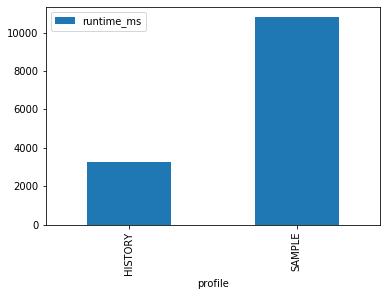

In [29]:
print('Mean runtime in ms')
pd.set_option('display.max_colwidth', 100)
profileSum = df.groupby(['profile']).sum()
profileSum.plot(kind='bar')
plt.show()

You can also use the Db2 Data Management Console directly to look at the package cache and the package cache history.

Run the following cell and log in using **DB2INST1** as the userid and password. The cell calls the console as a micro-service and includes part of the live user interface into a IFrame directly in this notebook.

Change the timeframe from **Latest** to **Last 1 hour** so you can see a history of package cache monitoring.

In [30]:
URL = database+'/console/?mode=compact#monitor/package_cache'+profileURL
print(URL)
IFrame(URL, width=1400, height=500)

http://localhost:11080/console/?mode=compact#monitor/package_cache?profile=SAMPLE


## Analyze a Single Statement
You can identify the slowest SQL statement and the slowest database to focus your attention. The next two cells will to that by scanning through our previous results.

In [31]:
print('Slowest SQL Statement')
slowestSQL = stmtSum['runtime_ms'].idxmax()
print(slowestSQL)

Slowest SQL Statement
SELECT DEPT.DEPTNO DNO, SUM(FLOAT(EMP.SALARY)) TOTAL_SALARY
  FROM EMPLOYEES EMP, DEPARTMENTS DEPT 
  WHERE DEPT.DEPTNO = EMP.DEPTNO 
      AND EMP.SALARY < 50000
      AND YEAR(EMP.HIREDATA) > 2010
  GROUP BY DEPT.DEPTNO
  ORDER BY DNO


In [32]:
print('Slowest Database')
slowestProfile = profileSum['runtime_ms'].idxmax()
print(slowestProfile)

Slowest Database
SAMPLE


A very powerful tool that you can include directly into your notebook is Visual Explain. Just like being able to explore the package cache history you can call the micro-service that provides a live intertive interface. In this example we will take the slowest statment on the slowest database and explain the statement. 

**3.1.1 Note:** Unfortunately there was a regression in ability to call this function directly through a URL. It is supported in 3.1 and will be addressed in 3.1.2. If you are currently using 3.1.1 please copy the SQL statement above, copy it into the Db2 Console SQL Editor and select the Visual Explain tool.

In [33]:
# Visually explain the access plan for an SQL Statement
slowestProfile='HISTORY'
slowestSQL='SELECT * FROM SYSCAT.TABLES'
profileURL = "?profile="+slowestProfile
stmt = slowestSQL.replace('\n', ' ').replace('\r', '')
URL = database+'/console/?mode=compact#sql/explain/create/'+stmt +profileURL
print(URL)
IFrame(URL, width=1400, height=500)

http://localhost:11080/console/?mode=compact#sql/explain/create/SELECT * FROM SYSCAT.TABLES?profile=HISTORY


### Comparing Results
Now we can create indexes to see if we can improve the overall performance of the workloads. The next cell will create indexes on the SALARY column of the Employees table as well as the DEPTO of both the DEPARTMENTS and EMPLOYEES tables. We can also update statistics to make sure the optimizer has the best results to work with. 

In [34]:
createIndexes = \
'''
CREATE INDEX ix_salary
ON EMPLOYEES(SALARY);

CREATE INDEX ix_empdept
ON EMPLOYEES(DEPTNO);

CREATE INDEX ix_dept
ON DEPARTMENTS(DEPTNO);
'''
profileList = ['SAMPLE','HISTORY']
scriptList = [createIndexes]
user = 'DB2INST1'
password = 'db2inst1'

for profile in profileList :
    print('Creating Indexes for Profile: '+profile)
    for script in scriptList :
        json = runSQL(profile, user, password, script)
        displayResults(json)
print('done')

Creating Indexes for Profile: SAMPLE
Statement: 0: CREATE INDEX ix_salary
ON EMPLOYEES(SALARY)
Runtime ms: 3967.9999351501465
No errors. Row Affected: 0

Statement: 1: CREATE INDEX ix_empdept
ON EMPLOYEES(DEPTNO)
Runtime ms: 2454.9999237060547
No errors. Row Affected: 0

Statement: 2: CREATE INDEX ix_dept
ON DEPARTMENTS(DEPTNO)
Runtime ms: 32.999999821186066
No errors. Row Affected: 0

Creating Indexes for Profile: HISTORY
Statement: 0: CREATE INDEX ix_salary
ON EMPLOYEES(SALARY)
Runtime ms: 971.0000157356262
No errors. Row Affected: 0

Statement: 1: CREATE INDEX ix_empdept
ON EMPLOYEES(DEPTNO)
Runtime ms: 261.00000739097595
No errors. Row Affected: 0

Statement: 2: CREATE INDEX ix_dept
ON DEPARTMENTS(DEPTNO)
Runtime ms: 48.99999871850014
No errors. Row Affected: 0

done


In [35]:
updateStats = \
'''
call sysproc.admin_cmd('RUNSTATS ON TABLE db2inst1.employees ON KEY COLUMNS and INDEXES ALL');
call sysproc.admin_cmd('RUNSTATS ON TABLE db2inst1.departments ON KEY COLUMNS and INDEXES ALL');
'''
profileList = ['SAMPLE','HISTORY']
scriptList = [updateStats]
user = 'DB2INST1'
password = 'db2inst1'

for profile in profileList :
    print('Updating Statistics for Profile: '+profile)
    for script in scriptList :
        json = runSQL(profile, user, password, script)
        displayResults(json)
print('done')

Updating Statistics for Profile: SAMPLE
Statement: 0: call sysproc.admin_cmd('RUNSTATS ON TABLE db2inst1.employees ON KEY COLUMNS and INDEXES ALL')
Runtime ms: 547.9999780654907
No errors. Row Affected: 0

Statement: 1: call sysproc.admin_cmd('RUNSTATS ON TABLE db2inst1.departments ON KEY COLUMNS and INDEXES ALL')
Runtime ms: 7.000000216066837
No errors. Row Affected: 0

Updating Statistics for Profile: HISTORY
Statement: 0: call sysproc.admin_cmd('RUNSTATS ON TABLE db2inst1.employees ON KEY COLUMNS and INDEXES ALL')
Runtime ms: 141.00000262260437
No errors. Row Affected: 0

Statement: 1: call sysproc.admin_cmd('RUNSTATS ON TABLE db2inst1.departments ON KEY COLUMNS and INDEXES ALL')
Runtime ms: 7.000000216066837
No errors. Row Affected: 0

done


Lets see if visual explain predicts any improvements.

**3.1.1 Note:** Unfortunately there was a regression in ability to call this function directly through a URL. It is supported in 3.1 and will be addressed in 3.1.2. If you are currently using 3.1.1 please rerun the visual explain analysis through the Db2 Console.

In [36]:
# Visually explain the access plan for an SQL Statement
slowestProfile='HISTORY'
slowestSQL='SELECT * FROM SYSCAT.TABLES'
profileURL = "?profile="+slowestProfile
stmt = slowestSQL.replace('\n', ' ').replace('\r', '')
IFrame(database+'/console/?mode=compact#sql/explain/create/'+stmt +profileURL, width=1400, height=480)

Now we will repeat the original workload performance run to see if there is a measureable difference in performance. 

In [37]:
profileList = ['SAMPLE','HISTORY']
scriptList = [sqlScriptWorkload1, sqlScriptWorkload2]
user = 'DB2INST1'
password = 'db2inst1'
profileReps = 2
scriptReps = 4

df = runScripts(profileList, scriptList, user, password, profileReps, scriptReps)

display(df)

Running repetition: 0
  Running scripts against: SAMPLE
    Running script repetition: 0
    Running script repetition: 1
    Running script repetition: 2
    Running script repetition: 3
  Running scripts against: HISTORY
    Running script repetition: 0
    Running script repetition: 1
    Running script repetition: 2
    Running script repetition: 3
Running repetition: 1
  Running scripts against: SAMPLE
    Running script repetition: 0
    Running script repetition: 1
    Running script repetition: 2
    Running script repetition: 3
  Running scripts against: HISTORY
    Running script repetition: 0
    Running script repetition: 1
    Running script repetition: 2
    Running script repetition: 3


,profile,index,statement,error,rows_affected,runtime_ms
0,SAMPLE,0,"WITH SALARYBY (DEPTNO, TOTAL) AS\n (SELECT DEPT.DEPTNO DNO, SUM(BIGINT(EMP.SALARY)) TOTAL_SAL...",,0,263.999999
1,SAMPLE,0,"SELECT DEPT.DEPTNO DNO, SUM(FLOAT(EMP.SALARY)) TOTAL_SALARY\n FROM EMPLOYEES EMP, DEPARTMENTS D...",,0,425.999999
2,SAMPLE,1,"SELECT DEPT.DEPTNO DNO, SUM(FLOAT(EMP.SALARY)) TOTAL_SALARY\n FROM EMPLOYEES EMP, DEPARTMENTS D...",,0,560.999990
3,SAMPLE,2,"SELECT DEPT.DEPTNO, DEPT.REVENUE\n FROM DEPARTMENTS DEPT WHERE DEPT.REVENUE > 450000000",,0,4.000000
4,SAMPLE,0,"WITH SALARYBY (DEPTNO, TOTAL) AS\n (SELECT DEPT.DEPTNO DNO, SUM(BIGINT(EMP.SALARY)) TOTAL_SAL...",,0,275.000006
...,...,...,...,...,...,...
60,HISTORY,2,"SELECT DEPT.DEPTNO, DEPT.REVENUE\n FROM DEPARTMENTS DEPT WHERE DEPT.REVENUE > 450000000",,0,1.000000
61,HISTORY,0,"WITH SALARYBY (DEPTNO, TOTAL) AS\n (SELECT DEPT.DEPTNO DNO, SUM(BIGINT(EMP.SALARY)) TOTAL_SAL...",,0,61.999999
62,HISTORY,0,"SELECT DEPT.DEPTNO DNO, SUM(FLOAT(EMP.SALARY)) TOTAL_SALARY\n FROM EMPLOYEES EMP, DEPARTMENTS D...",,0,81.000000
63,HISTORY,1,"SELECT DEPT.DEPTNO DNO, SUM(FLOAT(EMP.SALARY)) TOTAL_SALARY\n FROM EMPLOYEES EMP, DEPARTMENTS D...",,0,55.000000


In [38]:
print('Total runtime in ms')
pd.set_option('display.max_colwidth', 100)
stmtSum = df.groupby(['statement']).sum()
print(stmtSum)

Total runtime in ms
                                                                                                       runtime_ms
statement                                                                                                        
SELECT DEPT.DEPTNO DNO, SUM(FLOAT(EMP.SALARY)) TOTAL_SALARY\n  FROM EMPLOYEES EMP, DEPARTMENTS DE...  3550.999977
SELECT DEPT.DEPTNO DNO, SUM(FLOAT(EMP.SALARY)) TOTAL_SALARY\n  FROM EMPLOYEES EMP, DEPARTMENTS DE...  4893.999986
SELECT DEPT.DEPTNO, DEPT.REVENUE\n  FROM DEPARTMENTS DEPT WHERE DEPT.REVENUE > 450000000                40.000001
WITH SALARYBY (DEPTNO, TOTAL) AS\n    (SELECT DEPT.DEPTNO DNO, SUM(BIGINT(EMP.SALARY)) TOTAL_SALA...  2988.999993


Compare these results to your original performance without indexes.

Mean runtime in ms


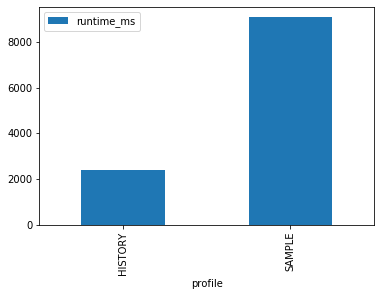

In [39]:
print('Mean runtime in ms')
pd.set_option('display.max_colwidth', 100)
profileSum = df.groupby(['profile']).sum()
profileSum.plot(kind='bar')
plt.show()

### Clean Up

If you want to run the lab again, or try with different indexes, you can use the cells below to drop either the current indexes or the original tables. 

Experiment with different SQL Statements, and different tables to see what your results look like. You can even try to create new cells that will run different workloads on different databases. 

In [40]:
dropIndexes = \
'''
DROP INDEX ix_salary;
DROP INDEX ix_empdept;
DROP INDEX ix_dept;
'''
profileList = ['SAMPLE','HISTORY']
scriptList = [dropIndexes]
user = 'DB2INST1'
password = 'db2inst1'

for profile in profileList :
    print('Profile: '+profile)
    for script in scriptList :
        json = runSQL(profile, user, password, script)
        displayResults(json)
print('done')

Profile: SAMPLE
Statement: 0: DROP INDEX ix_salary
Runtime ms: 56.0000017285347
No errors. Row Affected: 0

Statement: 1: DROP INDEX ix_empdept
Runtime ms: 16.00000075995922
No errors. Row Affected: 0

Statement: 2: DROP INDEX ix_dept
Runtime ms: 7.000000216066837
No errors. Row Affected: 0

Profile: HISTORY
Statement: 0: DROP INDEX ix_salary
Runtime ms: 18.99999938905239
No errors. Row Affected: 0

Statement: 1: DROP INDEX ix_empdept
Runtime ms: 7.000000216066837
No errors. Row Affected: 0

Statement: 2: DROP INDEX ix_dept
Runtime ms: 4.999999888241291
No errors. Row Affected: 0

done


In [41]:
dropTables = \
'''
DROP TABLE EMPLOYEES;
DROP TABLE DEPARTMENTS;
'''
profileList = ['SAMPLE','HISTORY']
scriptList = [dropTables]
user = 'DB2INST1'
password = 'db2inst1'

for profile in profileList :
    print('Profile: '+profile)
    for script in scriptList :
        json = runSQL(profile, user, password, script)
        displayResults(json)
print('done')

Profile: SAMPLE
Statement: 0: DROP TABLE EMPLOYEES
Runtime ms: 81.00000023841858
No errors. Row Affected: 0

Statement: 1: DROP TABLE DEPARTMENTS
Runtime ms: 12.000000104308128
No errors. Row Affected: 0

Profile: HISTORY
Statement: 0: DROP TABLE EMPLOYEES
Runtime ms: 21.99999988079071
No errors. Row Affected: 0

Statement: 1: DROP TABLE DEPARTMENTS
Runtime ms: 3.000000026077032
No errors. Row Affected: 0

done


#### Credits: IBM 2019, Peter Kohlmann [kohlmann@ca.ibm.com]